In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import sklearn.preprocessing, sklearn.decomposition
import seaborn as sns
import umap
import scipy.stats

In [2]:
x = pd.read_csv("original_data/Stage_5.Seurat.csv", index_col = 0)
metadata = pd.read_csv('original_data/cell_metadata.csv')
x.head()

,SST,PYY,GCG,TTR,PPY,TAC1,GC,INS,NTS,CCK,...,LANCL3,FAM193A,FMN1,TPM1,VWA8,ERMAP,PTGS1,HEYL,C9orf43,ANKRD20A4
stg5diff1_S5d0_b1.bcEKBI,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.716086,0.0,...,0.0,0.420816,0.0,1.829704,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcDAND,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,1.866169,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcGQEK,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.007309,0.0,2.073536,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcFOEC,0.000000,0.0,0.0,1.175463,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,1.700974,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcAVAX,1.272205,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.272205,0.0,0.000000,1.272205,0.0,0.0,0.0,0.0,0.0


### Standardized such that each gene has zero mean and unit variance over all cells

In [3]:
scaler = sklearn.preprocessing.StandardScaler()
pca = sklearn.decomposition.PCA(n_components = 30, random_state=0)
um = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 30, random_state=42,transform_seed=42)


In [4]:
y = metadata['CellWeek'].values.astype(int)

ix_tr = y != 7
ix_te = y == 7

x_tr = x[ix_tr]
x_te = x[ix_te]
y_tr = y[ix_tr]
y_te = y[ix_te]

meta_tr = metadata.loc[ix_tr]
meta_te = metadata.loc[ix_te]

In [5]:
normalized_x_tr = pd.DataFrame(scaler.fit_transform(x_tr), 
                               index = x_tr.index, columns = x_tr.columns)

x1 = normalized_x_tr['TOP2A']
rs = {}
for g in normalized_x_tr.columns: 
    
    x2 = normalized_x_tr[g]
    r, pval = scipy.stats.pearsonr(x1, x2)

    rs[g] = r
rs = pd.Series(rs)
(rs > 0.15).value_counts()

normalized_x_tr_f = normalized_x_tr.loc[:,rs < 0.15]
xp_tr = pca.fit_transform(normalized_x_tr_f)
xu_tr = um.fit_transform(xp_tr) 


normalized_x_te = pd.DataFrame(scaler.transform(x_te), 
                               index = x_te.index, columns = x_te.columns)
normalized_x_te_f = normalized_x_te.loc[:,rs < 0.15]
xp_te = pca.transform(normalized_x_te_f)
xu_te = um.transform(xp_te)


### Train and Test Data seperate by Time points

In [6]:
y = metadata['CellWeek'].values.astype(int)
x_l = [normalized_x_tr_f.loc[y_tr == 0,].values,
       normalized_x_tr_f.loc[y_tr == 1,].values,
       normalized_x_tr_f.loc[y_tr == 2,].values,
       normalized_x_tr_f.loc[y_tr == 3,].values,
       normalized_x_tr_f.loc[y_tr == 4,].values,
       normalized_x_tr_f.loc[y_tr == 5,].values,
       normalized_x_tr_f.loc[y_tr == 6,].values,
       normalized_x_te_f.loc[y_te == 7,].values]
xp_l = [xp_tr[y_tr == 0,],
        xp_tr[y_tr == 1,],
        xp_tr[y_tr == 2,],
        xp_tr[y_tr == 3,],
        xp_tr[y_tr == 4,],
        xp_tr[y_tr == 5,],
        xp_tr[y_tr == 6,],
        xp_te[y_te == 7,]]
xu_l = [xu_tr[y_tr == 0,],
        xu_tr[y_tr == 1,],
        xu_tr[y_tr == 2,],
        xu_tr[y_tr == 3,],
        xu_tr[y_tr == 4,],
        xu_tr[y_tr == 5,],
        xu_tr[y_tr == 6,],
        xu_te[y_te == 7,]]

x_l = [torch.from_numpy(a).float() for a in x_l]
xp_l = [torch.from_numpy(a).float() for a in xp_l]
xu_l = [torch.from_numpy(a).float() for a in xu_l]

In [7]:
celltype_ = [meta_tr['Assigned_cluster'][(y_tr == 0)],
             meta_tr['Assigned_cluster'][(y_tr == 1)],
             meta_tr['Assigned_cluster'][(y_tr == 2)],
             meta_tr['Assigned_cluster'][(y_tr == 3)],
             meta_tr['Assigned_cluster'][(y_tr == 4)],
             meta_tr['Assigned_cluster'][(y_tr == 5)],
             meta_tr['Assigned_cluster'][(y_tr == 6)],
             meta_te['Assigned_cluster'][(y_te == 7)]]
genes = normalized_x_tr_f.columns

In [8]:
unique_cell_types = metadata['Assigned_cluster'].unique()
default_colors = sns.color_palette("tab20", len(unique_cell_types))
color_palette_dict = {cell_type: color for cell_type, color in zip(unique_cell_types, default_colors)}

In [9]:
torch.save({
    'x': x_l, 
    'xp': xp_l, 
    'xu': xu_l, 
    'y': [0,1,2,3,4,5,6,7],
    'celltype': celltype_,
    'genes':genes,
    'Types':unique_cell_types,
    'colors':color_palette_dict
}, 'leaveout7/fate_train.pt')

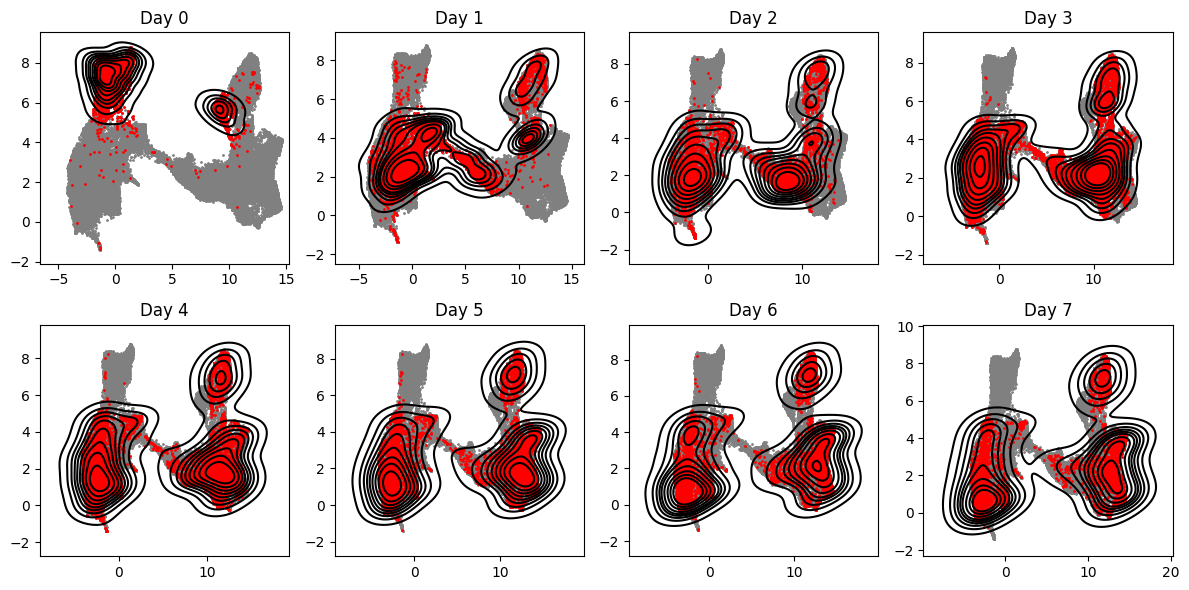

In [10]:
days = sorted(metadata['CellWeek'].unique())

fig, ax = plt.subplots(2, 4, figsize = (12, 6))
axs = ax.flatten()

for ai, d in enumerate(days): 
    ax = axs[ai]
    ax.scatter(xu_tr[:,0], xu_tr[:,1], s = 1, color = 'gray')
    ax.scatter(xu_te[:,0], xu_te[:,1], s = 1, color = 'gray')
    if d != 7:
        ax.scatter(xu_tr[y_tr == d,0], xu_tr[y_tr==d,1], s = 1, color = 'red')
        sns.kdeplot(x=xu_tr[y_tr== d,0], y=xu_tr[y_tr == d,1], color = 'k',ax=ax)
    else:
        ax.scatter(xu_te[y_te == d,0], xu_te[y_te==d,1], s = 1, color = 'red')
        sns.kdeplot(x=xu_te[y_te== d,0], y=xu_te[y_te == d,1], color = 'k',ax=ax)

    ax.set_title('Day {}'.format(d))
    
plt.tight_layout() 

In [11]:
from joblib import dump
dump(um, 'leaveout7/um_transformer.joblib')

['leaveout7/um_transformer.joblib']